Importing Libraries

In [6]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json
from scipy.signal import savgol_filter

Loading Local Json, Correcting time delta

In [8]:
# Load the JSON file
json_file_path = "data/siotch-default-rtdb-export.json"
with open(json_file_path, "r") as file:
    data = json.load(file)

# Define the actual export time
export_time = datetime.strptime("2024-12-11 15:40:00", "%Y-%m-%d %H:%M:%S")

# Define the erroneous end time
end_time = datetime.strptime("2000-01-10 22:00:49", "%Y-%m-%d %H:%M:%S")

# Calculate the time delta
time_delta = export_time - end_time

# Correct the timestamps
for key, entry in data.get("air_quality", {}).items():
    erroneous_timestamp = datetime.strptime(entry["timestamp"], "%Y-%m-%d %H:%M:%S")
    corrected_timestamp = erroneous_timestamp + time_delta
    entry["timestamp"] = corrected_timestamp.strftime("%Y-%m-%d %H:%M:%S")

# Save the corrected JSON to a new file
corrected_json_file_path = "siotch-corrected-timestamps.json"
with open(corrected_json_file_path, "w") as corrected_file:
    json.dump(data, corrected_file, indent=2)

corrected_json_file_path

'siotch-corrected-timestamps.json'

Converting to Panda frame

In [17]:
# Convert the data to a pandas DataFrame
records = []
for entry in data.get("air_quality", {}).values():  # Accessing the nested 'air_quality' key
    # Check if the required keys exist
    if "timestamp" in entry and "arch" in entry:
        records.append({
            "timestamp": entry["timestamp"],
            "arch": entry["arch"],
            "pm25": entry.get("pm25", None),  # Use .get() to avoid KeyError if 'pm25' doesn't exist
            "temperature": entry.get("temperature", None),
            "humidity": entry.get("humidity", None)
        })

df = pd.DataFrame(records)

# Check if 'timestamp' column exists before converting
if 'timestamp' in df.columns:
    # Convert timestamp to datetime
    df["timestamp"] = pd.to_datetime(df["timestamp"])

Converting Dataframe

In [18]:
# Convert the data to a pandas DataFrame
records = []
for entry in data.get("air_quality", {}).values():  # Accessing the nested 'air_quality' key
    # Check if the required keys exist
    if "timestamp" in entry and "arch" in entry:
        records.append({
            "timestamp": entry["timestamp"],
            "arch": entry["arch"],
            "pm25": entry.get("pm25", None),  # Use .get() to avoid KeyError if 'pm25' doesn't exist
            "temperature": entry.get("temperature", None),
            "humidity": entry.get("humidity", None)
        })

df = pd.DataFrame(records)

# Check if 'timestamp' column exists before converting
if 'timestamp' in df.columns:
    # Convert timestamp to datetime
    df["timestamp"] = pd.to_datetime(df["timestamp"])

Filtering

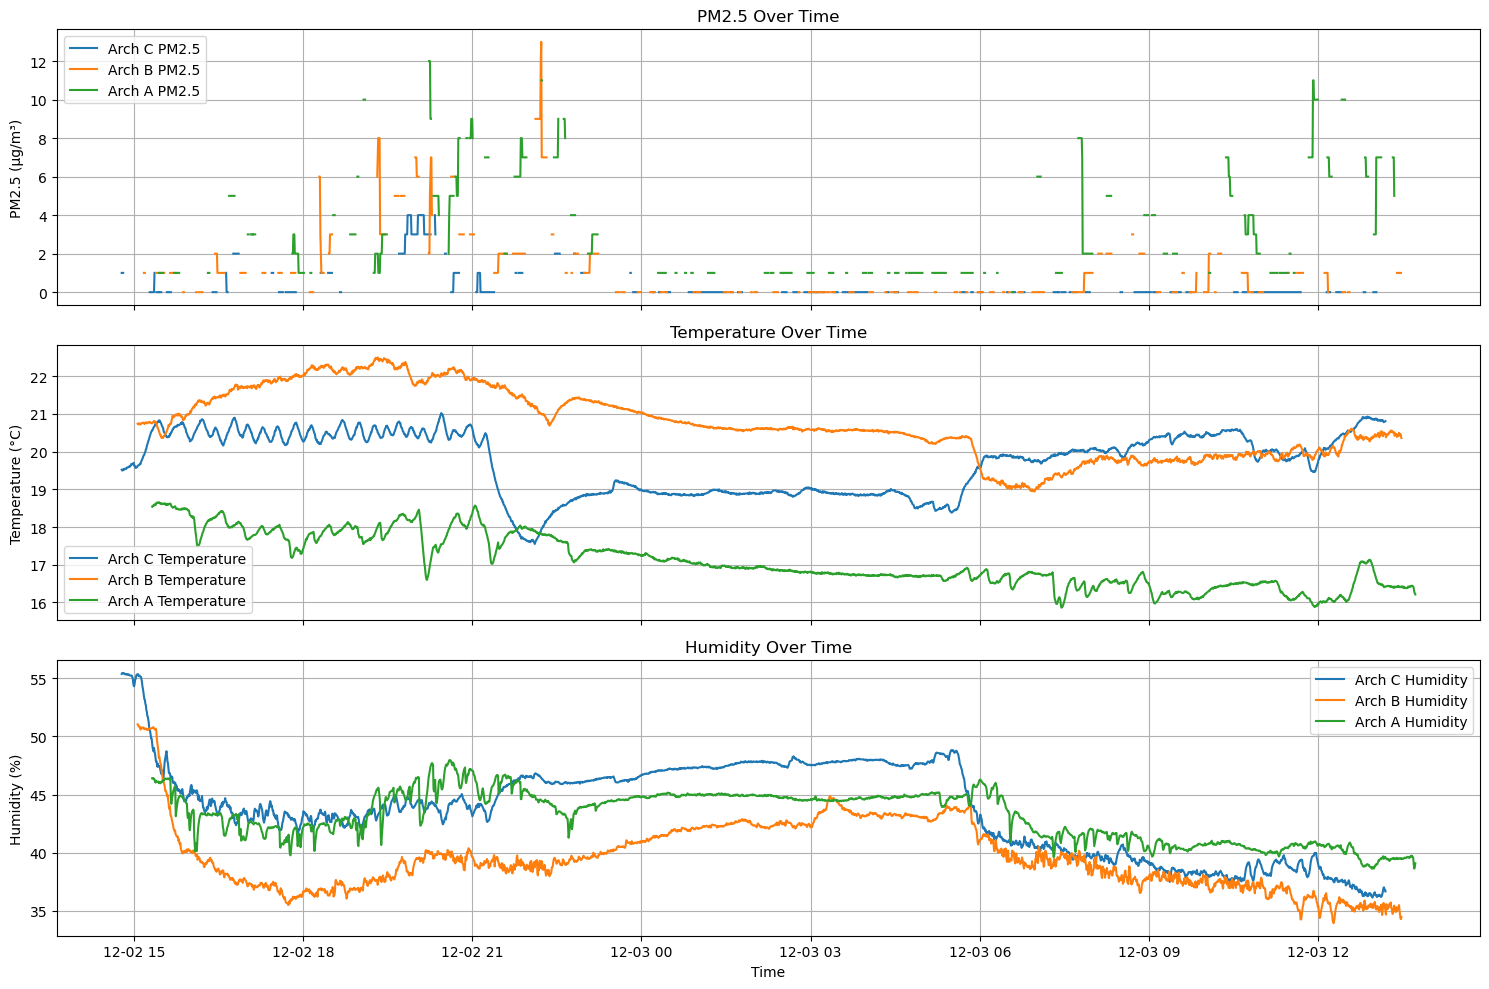

In [21]:
# Define the start and end time for filtering
start_time = datetime.strptime("2024-12-02 14:47:06", "%Y-%m-%d %H:%M:%S")
end_time = datetime.strptime("2024-12-03 15:28:06", "%Y-%m-%d %H:%M:%S")

# Filter the DataFrame to only include data within the specified time period
filtered_df = df[(df["timestamp"] >= start_time) & (df["timestamp"] <= end_time)]

# Plot data with overlays for each arch
arches = filtered_df["arch"].unique()

# Create subplots for PM2.5, temperature, and humidity
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

# PM2.5
for arch in arches:
    arch_data = filtered_df[filtered_df["arch"] == arch]
    axes[0].plot(arch_data["timestamp"], arch_data["pm25"], label=f"{arch} PM2.5")
axes[0].set_title("PM2.5 Over Time")
axes[0].set_ylabel("PM2.5 (µg/m³)")
axes[0].grid(True)
axes[0].legend()

# Temperature
for arch in arches:
    arch_data = filtered_df[filtered_df["arch"] == arch]
    axes[1].plot(arch_data["timestamp"], arch_data["temperature"], label=f"{arch} Temperature")
axes[1].set_title("Temperature Over Time")
axes[1].set_ylabel("Temperature (°C)")
axes[1].grid(True)
axes[1].legend()

# Humidity
for arch in arches:
    arch_data = filtered_df[filtered_df["arch"] == arch]
    axes[2].plot(arch_data["timestamp"], arch_data["humidity"], label=f"{arch} Humidity")
axes[2].set_title("Humidity Over Time")
axes[2].set_ylabel("Humidity (%)")
axes[2].grid(True)
axes[2].legend()

# Set common x-axis label
plt.xlabel("Time")
plt.tight_layout()
plt.show()


Showing PM2.5 levels, smoothed with window size 10 and interpolated, with WHO recommended guidance

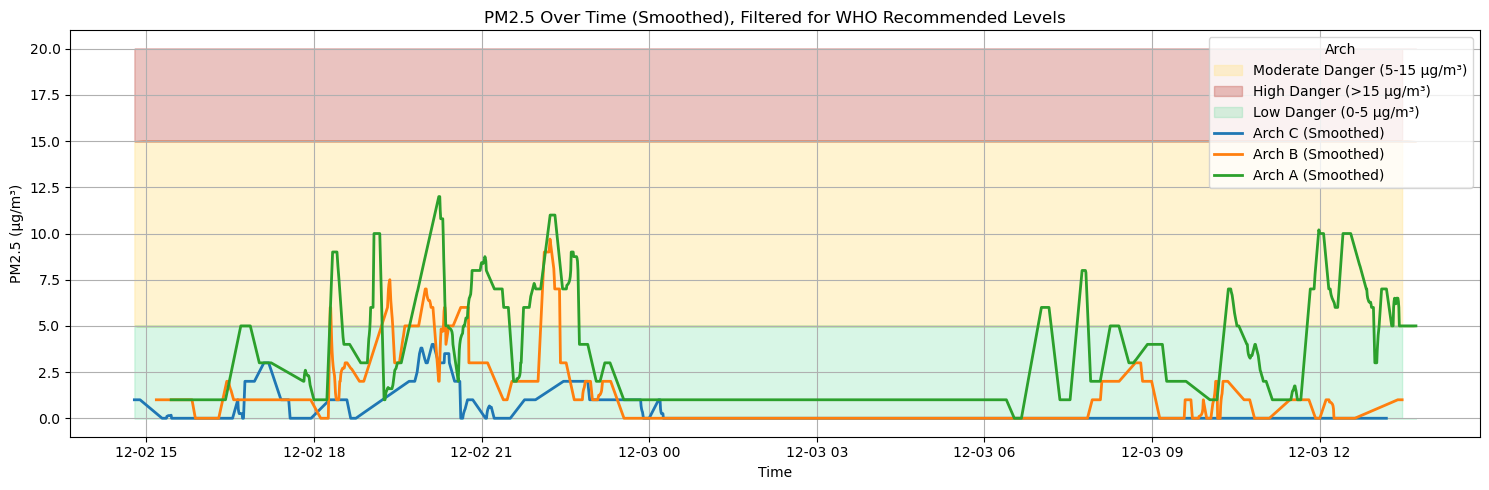

In [31]:
filtered_df = filtered_df.copy()

# Apply large smoothing window (window size 10) for more pronounced smoothing of PM2.5
filtered_df['pm25_smooth'] = filtered_df.groupby('arch')['pm25'].rolling(window=10, min_periods=1).mean().reset_index(level=0, drop=True)

# Apply linear interpolation for missing values in PM2.5
filtered_df['pm25_smooth'] = filtered_df.groupby('arch', group_keys=False)['pm25_smooth'].apply(lambda x: x.interpolate(method='linear', limit_direction='forward'))

# Plotting the smoothed PM2.5 data
plt.figure(figsize=(15, 5))

# Plot the yellow, red, and green regions for PM2.5
plt.fill_between(filtered_df["timestamp"], 5, 15, color="#FFE8A3", alpha=0.5, label="Moderate Danger (5-15 µg/m³)")
plt.fill_between(filtered_df["timestamp"], 15, 20, color="#BC3B2F", alpha=0.3, label="High Danger (>15 µg/m³)")
plt.fill_between(filtered_df["timestamp"], 0, 5, color="#3DD483", alpha=0.2, label="Low Danger (0-5 µg/m³)")

# Plot the smoothed PM2.5 data for each arch
for arch in filtered_df['arch'].unique():
    arch_data = filtered_df[filtered_df["arch"] == arch]
    plt.plot(arch_data["timestamp"], arch_data["pm25_smooth"], label=f"{arch} (Smoothed)", linestyle='-', linewidth=2)

# Add labels and title for the smoothed plot
plt.title("PM2.5 Over Time (Smoothed), Filtered for WHO Recommended Levels")
plt.xlabel("Time")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend(title="Arch")
plt.grid(True)

# Tighten layout
plt.tight_layout()

# Show the smoothed plot
plt.show()


Check Ins per hour (line graph)

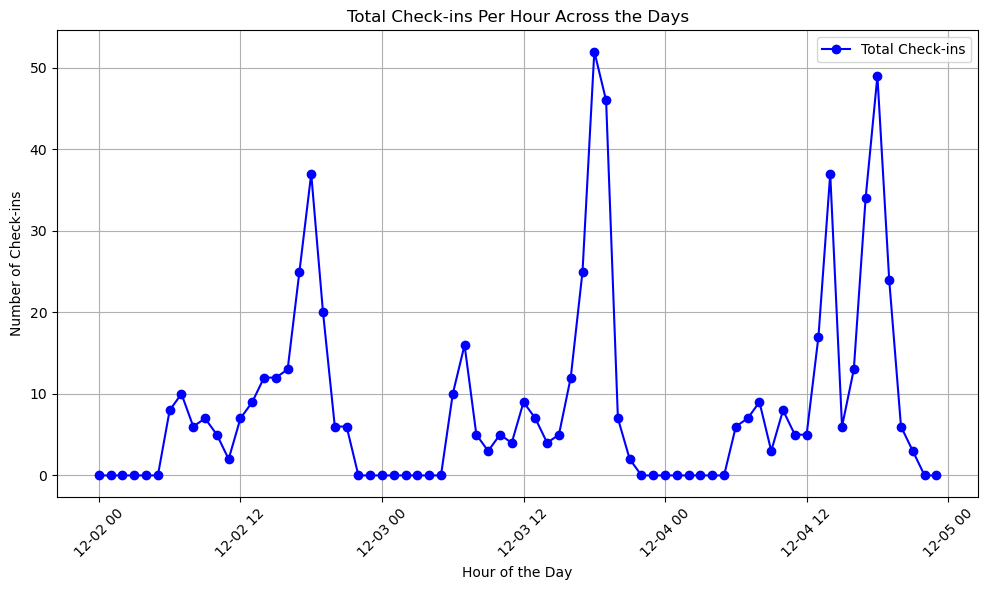

In [33]:
# Load the Excel file
file_path = "data/check_ins.xlsx"  # Replace with your actual file path
df = pd.read_excel(file_path)

# Assuming 'Hour' column is the first column with the hours of the day, and the second column contains check-ins
df['Hour'] = pd.to_datetime(df['Hour'], format='%d/%m/%y %H:%M')  # Adjust this if needed for your actual time format
df['Checkins'] = df.iloc[:, 1]  # Extracting check-in data from the second column

# Plotting Total Checkins Per Hour
plt.figure(figsize=(10, 6))
plt.plot(df['Hour'], df['Checkins'], marker='o', color='b', label='Total Check-ins')

# Formatting the plot
plt.title("Total Check-ins Per Hour Across the Days")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Check-ins")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

# Show the plot
plt.show()


Check-Ins Per Hour, adjusted to bar chart (n of check-ins between 6-7am)

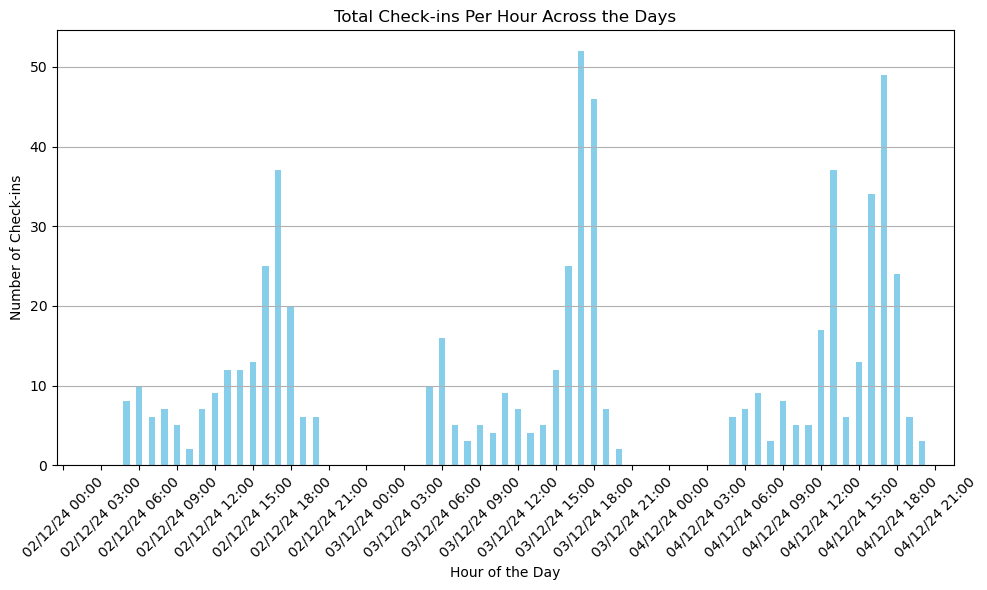

In [35]:
# Load the Excel file
file_path = "data/check_ins.xlsx"  # Replace with your actual file path
df = pd.read_excel(file_path)

# Assuming 'Hour' column is the first column with the hours of the day, and the second column contains check-ins
df['Hour'] = pd.to_datetime(df['Hour'], format='%d/%m/%y %H:%M')  # Adjust this if needed for your actual time format
df['Checkins'] = df.iloc[:, 1]  # Extracting check-in data from the second column

# Group the data by the hour and sum the check-ins for each hour
df['Hour_rounded'] = df['Hour'].dt.floor('H')  # Round down to the nearest hour
hourly_checkins = df.groupby('Hour_rounded')['Checkins'].sum()

# Plotting the total check-ins per hour as a bar chart
plt.figure(figsize=(10, 6))
hourly_checkins.plot(kind='bar', color='skyblue')

# Simplify the x-axis labels by displaying every 3rd hour
plt.xticks(ticks=range(0, len(hourly_checkins), 3), labels=hourly_checkins.index.strftime('%d/%m/%y %H:%M')[::3], rotation=45)

# Formatting the plot
plt.title("Total Check-ins Per Hour Across the Days")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Check-ins")
plt.grid(True, axis='y')
plt.tight_layout()

# Show the plot
plt.show()


Normalising Check-Ins

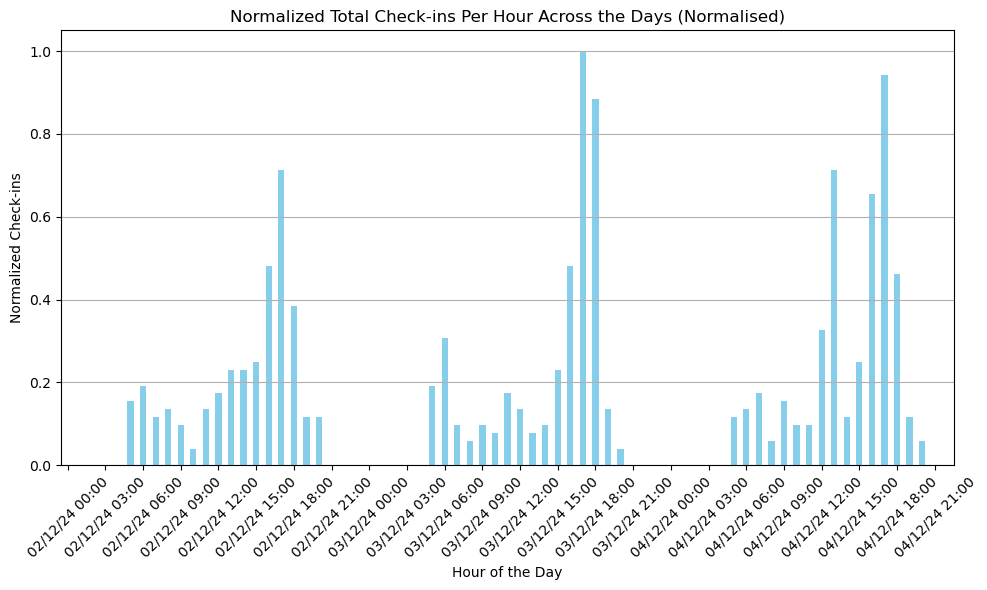

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = "data/check_ins.xlsx"  # Replace with your actual file path
df = pd.read_excel(file_path)

# Assuming 'Hour' column is the first column with the hours of the day, and the second column contains check-ins
df['Hour'] = pd.to_datetime(df['Hour'], format='%d/%m/%y %H:%M')  # Adjust this if needed for your actual time format
df['Checkins'] = df.iloc[:, 1]  # Extracting check-in data from the second column

# Group the data by the hour and sum the check-ins for each hour
df['Hour_rounded'] = df['Hour'].dt.floor('H')  # Round down to the nearest hour
hourly_checkins = df.groupby('Hour_rounded')['Checkins'].sum()

# Normalize the check-ins using Min-Max scaling
hourly_checkins_normalized = (hourly_checkins - hourly_checkins.min()) / (hourly_checkins.max() - hourly_checkins.min())

# Plotting the normalized check-ins per hour as a bar chart
plt.figure(figsize=(10, 6))
hourly_checkins_normalized.plot(kind='bar', color='skyblue')

# Simplify the x-axis labels by displaying every 3rd hour
plt.xticks(ticks=range(0, len(hourly_checkins_normalized), 3), 
           labels=hourly_checkins_normalized.index.strftime('%d/%m/%y %H:%M')[::3], 
           rotation=45)

# Formatting the plot
plt.title("Normalized Total Check-ins Per Hour Across the Days (Normalised)")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Check-ins")
plt.grid(True, axis='y')
plt.tight_layout()

# Show the plot
plt.show()

Normalising PM2.5

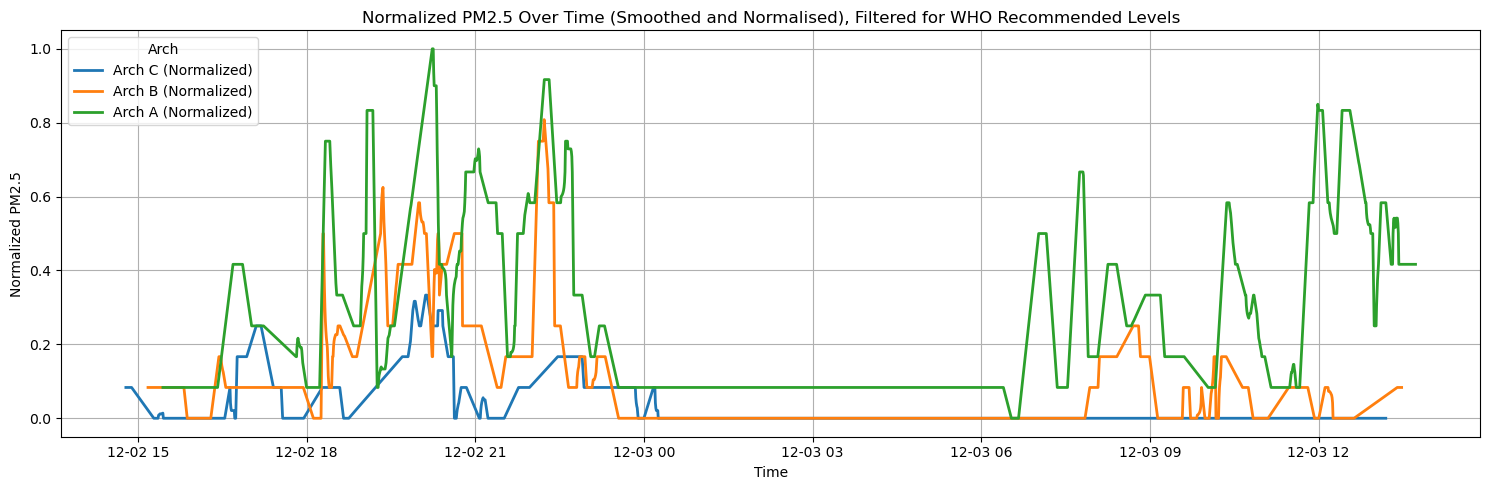

In [42]:
# Apply large smoothing window (window size 10) for more pronounced smoothing of PM2.5
filtered_df['pm25_smooth'] = filtered_df.groupby('arch')['pm25'].rolling(window=10, min_periods=1).mean().reset_index(level=0, drop=True)

# Apply linear interpolation for missing values in PM2.5
filtered_df['pm25_smooth'] = filtered_df.groupby('arch', group_keys=False)['pm25_smooth'].apply(lambda x: x.interpolate(method='linear', limit_direction='forward'))

# Normalize the smoothed PM2.5 data (scaling to range 0-1)
filtered_df['pm25_smooth_normalized'] = (filtered_df['pm25_smooth'] - filtered_df['pm25_smooth'].min()) / (filtered_df['pm25_smooth'].max() - filtered_df['pm25_smooth'].min())

# Plotting the normalized PM2.5 data
plt.figure(figsize=(15, 5))

# Plot the normalized smoothed PM2.5 data for each arch
for arch in filtered_df['arch'].unique():
    arch_data = filtered_df[filtered_df["arch"] == arch]
    plt.plot(arch_data["timestamp"], arch_data["pm25_smooth_normalized"], label=f"{arch} (Normalized)", linestyle='-', linewidth=2)

# Add labels and title for the normalized plot
plt.title("Normalized PM2.5 Over Time (Smoothed and Normalised), Filtered for WHO Recommended Levels")
plt.xlabel("Time")
plt.ylabel("Normalized PM2.5")
plt.legend(title="Arch")
plt.grid(True)

# Tighten layout
plt.tight_layout()

# Show the normalized plot
plt.show()


Resampling PM2.5 to hourly and Overlaying on Check-Ins

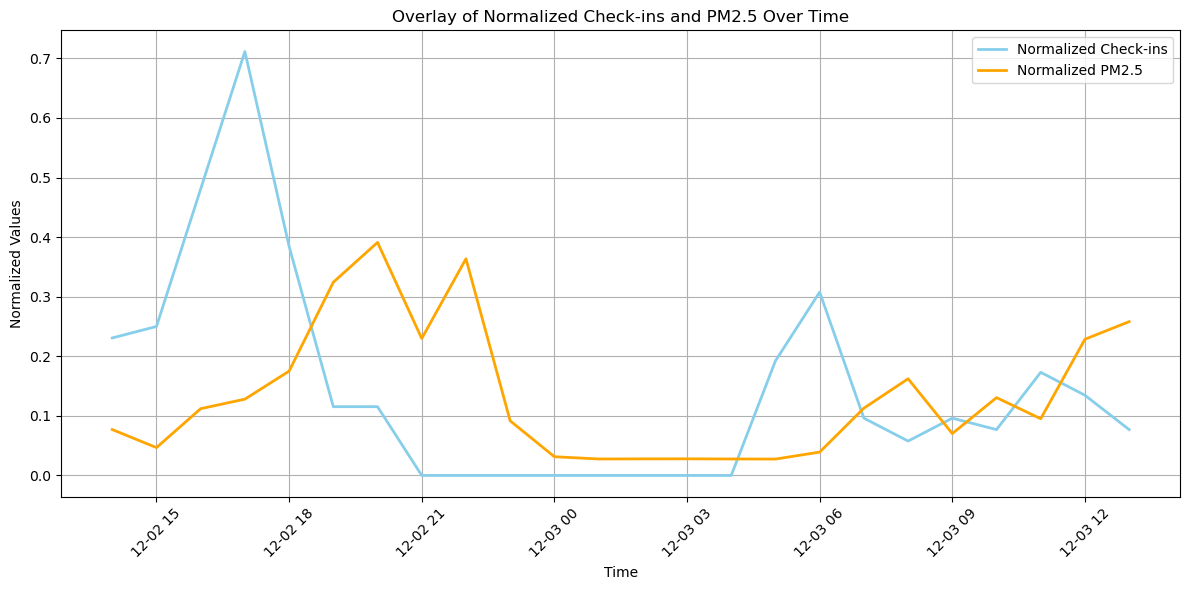

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and process check-ins data
checkins_path = "data/check_ins.xlsx"  # Replace with your actual file path
checkins_df = pd.read_excel(checkins_path)

checkins_df['Hour'] = pd.to_datetime(checkins_df['Hour'], format='%d/%m/%y %H:%M')
checkins_df['Checkins'] = checkins_df.iloc[:, 1]
checkins_df['Hour_rounded'] = checkins_df['Hour'].dt.floor('H')

hourly_checkins = checkins_df.groupby('Hour_rounded')['Checkins'].sum()
hourly_checkins_normalized = (hourly_checkins - hourly_checkins.min()) / (hourly_checkins.max() - hourly_checkins.min())

# Load and process PM2.5 data
# Assuming 'filtered_df' contains the PM2.5 data
filtered_df['pm25_smooth'] = filtered_df.groupby('arch')['pm25'].rolling(window=10, min_periods=1).mean().reset_index(level=0, drop=True)
filtered_df['pm25_smooth'] = filtered_df.groupby('arch', group_keys=False)['pm25_smooth'].apply(lambda x: x.interpolate(method='linear', limit_direction='forward'))
filtered_df['pm25_smooth_normalized'] = (filtered_df['pm25_smooth'] - filtered_df['pm25_smooth'].min()) / (filtered_df['pm25_smooth'].max() - filtered_df['pm25_smooth'].min())

# Resample PM2.5 data to hourly basis (assuming 'timestamp' column is in datetime format)
filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])
filtered_df.set_index('timestamp', inplace=True)
hourly_pm25_normalized = filtered_df.resample('H')['pm25_smooth_normalized'].mean()

# Align the time periods for both datasets
aligned_time = hourly_checkins.index.intersection(hourly_pm25_normalized.index)

# Plot both normalized check-ins and PM2.5 data
plt.figure(figsize=(12, 6))

# Plot normalized check-ins data
plt.plot(hourly_checkins_normalized[aligned_time], label='Normalized Check-ins', color='skyblue', linestyle='-', linewidth=2)

# Plot normalized PM2.5 data
plt.plot(hourly_pm25_normalized[aligned_time], label='Normalized PM2.5', color='orange', linestyle='-', linewidth=2)

# Add labels, title, and legend
plt.title("Overlay of Normalized Check-ins and PM2.5 Over Time")
plt.xlabel("Time")
plt.ylabel("Normalized Values")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Tight layout for better presentation
plt.tight_layout()

# Show the plot
plt.show()


Now, testing Correlations

Pearson Correlation (no lag): -0.04771735876514632


/Users/CallumHargrove/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/CallumHargrove/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


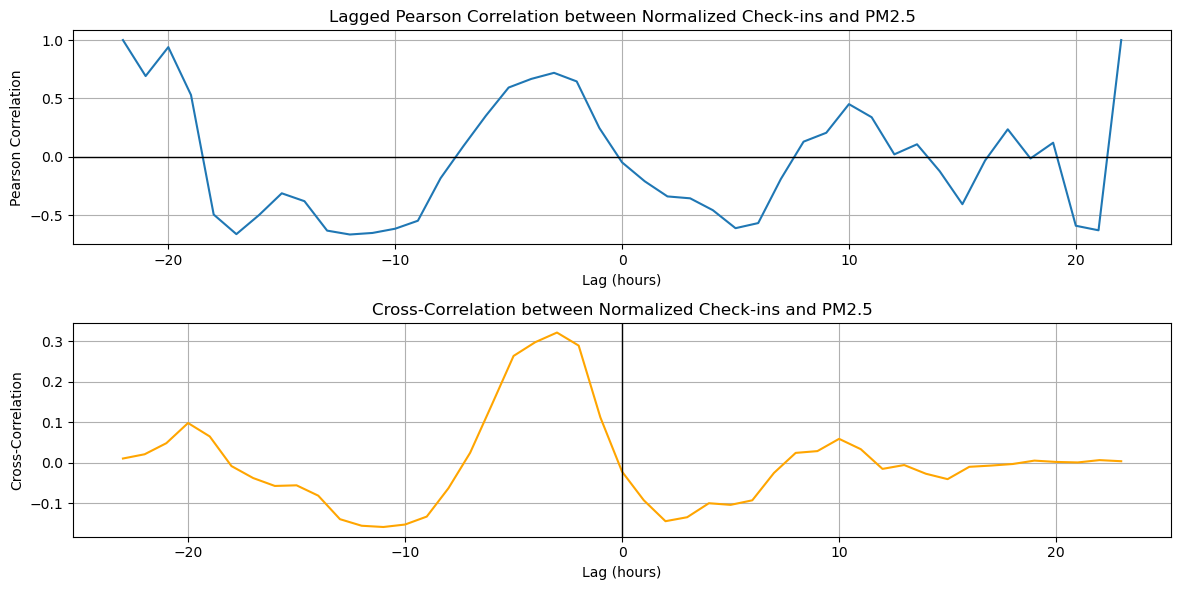

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.signal import correlate

# Resample and align both time series (check-ins and PM2.5)
aligned_time = hourly_checkins.index.intersection(hourly_pm25_normalized.index)
checkins_data = hourly_checkins_normalized[aligned_time]
pm25_data = hourly_pm25_normalized[aligned_time]

# Step 1: Pearson Correlation Coefficient (without lag)
pearson_corr = checkins_data.corr(pm25_data)
print(f"Pearson Correlation (no lag): {pearson_corr}")

# Step 2: Lagged Correlation (we'll check lags from -24 hours to +24 hours)
lags = np.arange(-24, 25)  # Lags from -24 hours to +24 hours
lagged_correlations = []

for lag in lags:
    # Shift PM2.5 by 'lag' hours
    shifted_pm25 = pm25_data.shift(lag)
    
    # Calculate Pearson correlation
    correlation = checkins_data.corr(shifted_pm25)
    lagged_correlations.append(correlation)

# Step 3: Cross-Correlation (using scipy correlate function)
cross_corr = correlate(checkins_data - np.mean(checkins_data), pm25_data - np.mean(pm25_data), mode='full')
cross_corr_lags = np.arange(-len(checkins_data) + 1, len(checkins_data))

# Plot results
plt.figure(figsize=(12, 6))

# Plot the Pearson correlation at various lags
plt.subplot(2, 1, 1)
plt.plot(lags, lagged_correlations, label="Pearson Correlation with Lag")
plt.axhline(0, color='black', linewidth=1)
plt.title("Lagged Pearson Correlation between Normalized Check-ins and PM2.5")
plt.xlabel("Lag (hours)")
plt.ylabel("Pearson Correlation")
plt.grid(True)
plt.tight_layout()

# Plot Cross-Correlation
plt.subplot(2, 1, 2)
plt.plot(cross_corr_lags, cross_corr, label="Cross-Correlation", color='orange')
plt.axvline(0, color='black', linewidth=1)
plt.title("Cross-Correlation between Normalized Check-ins and PM2.5")
plt.xlabel("Lag (hours)")
plt.ylabel("Cross-Correlation")
plt.grid(True)
plt.tight_layout()

plt.show()

In [50]:
# Check the variance of both time series
checkins_variance = checkins_data.var()
pm25_variance = pm25_data.var()

print(f"Check-ins Variance: {checkins_variance}")
print(f"PM2.5 Variance: {pm25_variance}")

# Check if either series has constant values
if checkins_variance == 0:
    print("Check-ins data has zero variance (constant values).")
if pm25_variance == 0:
    print("PM2.5 data has zero variance (constant values).")


Check-ins Variance: 0.031769895377754924
PM2.5 Variance: 0.01245032641983108


Rolling Window Correlation Heatmap (updated with NaN handling)

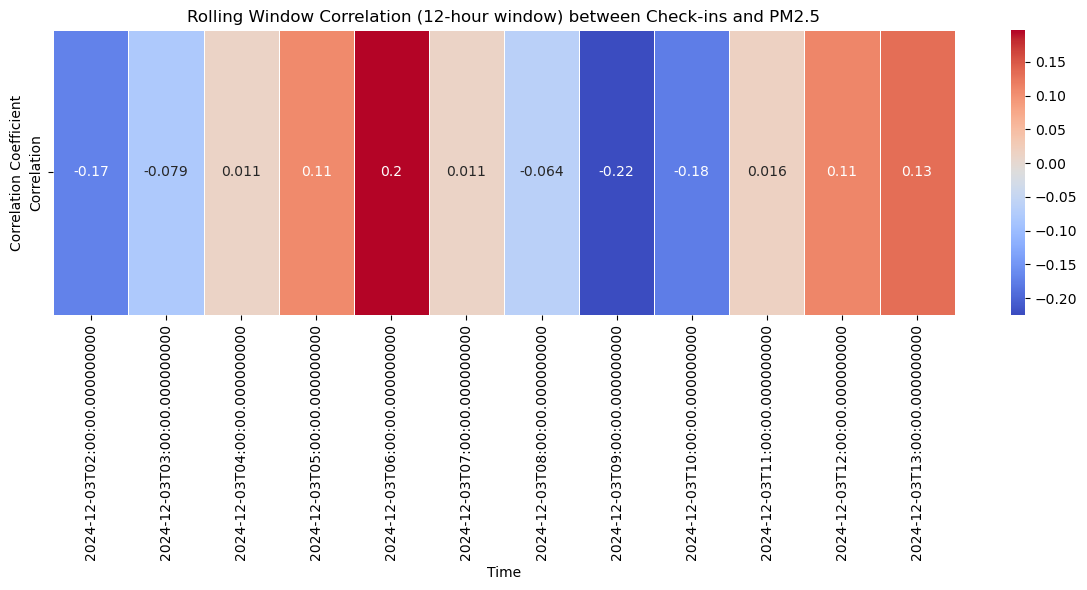

In [49]:
# Try a smaller rolling window size (e.g., 24 hours)
window_size = 12  # Trying with a smaller window size
rolling_corr = []

for i in range(len(checkins_data) - window_size):
    window_checkins = checkins_data[i:i+window_size]
    window_pm25 = pm25_data[i:i+window_size]
    
    # Avoid calculating correlation if there's insufficient data (NaN handling)
    correlation = window_checkins.corr(window_pm25)
    if not np.isnan(correlation):  # Only append valid correlations
        rolling_corr.append(correlation)

# Check if rolling_corr has any valid values
if rolling_corr:
    rolling_corr_df = pd.DataFrame(rolling_corr, columns=['Correlation'])
    rolling_corr_df.index = checkins_data.index[window_size:]

    # Plot rolling correlation heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(rolling_corr_df.T, cmap='coolwarm', annot=True, cbar=True, linewidths=0.5)
    plt.title(f"Rolling Window Correlation ({window_size}-hour window) between Check-ins and PM2.5")
    plt.xlabel("Time")
    plt.ylabel("Correlation Coefficient")
    plt.tight_layout()
    plt.show()
else:
    print(f"No valid rolling correlations found with a {window_size}-hour window size.")
